In [1]:
import pandas as pd
import regex as re
import matplotlib.pyplot as plt
import nltk

# Download NLTK stopwords (optional for later NLP use)
nltk.download('stopwords', quiet=True)

print("Libraries imported successfully!")


Libraries imported successfully!


In [2]:
# List of suspicious keywords and emojis
KEYWORDS = [
    "mdma","lsd","mephedrone","ecstasy","ganja","weed",
    "stuff","gear","party pills","💊","💉","🔥 deal"
]

# Normalize keywords to lowercase
KEYWORDS = [k.lower() for k in KEYWORDS]
print("Keyword list loaded:", KEYWORDS)


Keyword list loaded: ['mdma', 'lsd', 'mephedrone', 'ecstasy', 'ganja', 'weed', 'stuff', 'gear', 'party pills', '💊', '💉', '🔥 deal']


In [3]:
data = pd.DataFrame({
    "id":[1,2,3,4,5],
    "platform":["Telegram","Instagram","Telegram","WhatsApp","Instagram"],
    "message":[
        "Fresh MDMA 💊 — DM for price",
        "Party tonight? legit stuff only",
        "Best LSD tabs in city, quick drop",
        "Tea at 6? bring snacks",             # benign message
        "🔥 deal on party pills - limited"
    ]
})
data


,id,platform,message
0,1,Telegram,Fresh MDMA 💊 — DM for price
1,2,Instagram,Party tonight? legit stuff only
2,3,Telegram,"Best LSD tabs in city, quick drop"
3,4,WhatsApp,Tea at 6? bring snacks
4,5,Instagram,🔥 deal on party pills - limited


In [4]:
def normalize(text: str) -> str:
    """Convert text to lowercase and remove extra spaces."""
    return re.sub(r"\s+", " ", text.casefold()).strip()

def spaced_variant(word: str) -> str:
    r"""Handles spaced/obfuscated keywords: party -> p\W*a\W*r\W*t\W*y"""
    return r"".join([re.escape(ch) + r"\W*" for ch in word])

def detect_terms(text: str, keywords=KEYWORDS):
    """Return a list of detected keywords in the text."""
    t = normalize(text)
    hits = set()
    for kw in keywords:
        if kw in t:
            hits.add(kw)
        else:
            if re.search(spaced_variant(kw), t, flags=re.I):
                hits.add(kw)
    return sorted(hits)


In [5]:
data["matches"] = data["message"].apply(detect_terms)
data["flagged"] = data["matches"].apply(lambda x: len(x) > 0)
data


,id,platform,message,matches,flagged
0,1,Telegram,Fresh MDMA 💊 — DM for price,"[mdma, 💊]",True
1,2,Instagram,Party tonight? legit stuff only,[stuff],True
2,3,Telegram,"Best LSD tabs in city, quick drop",[lsd],True
3,4,WhatsApp,Tea at 6? bring snacks,[],False
4,5,Instagram,🔥 deal on party pills - limited,"[party pills, 🔥 deal]",True


Flagged rate: 80.00%

Flag rate by platform:
 platform
Instagram    1.0
Telegram     1.0
WhatsApp     0.0
Name: flagged, dtype: float64


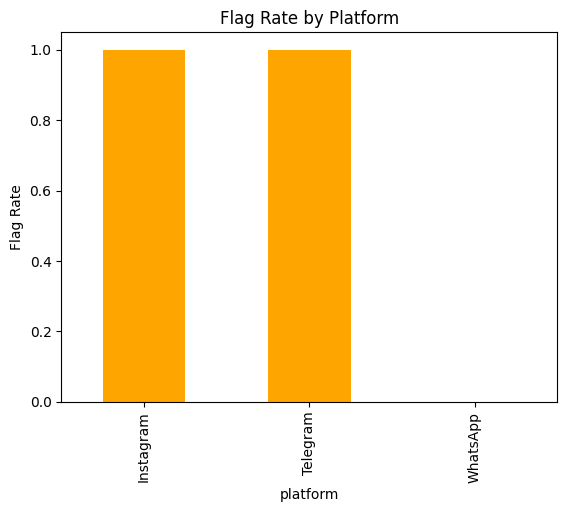

In [6]:
flag_rate = data["flagged"].mean()
print(f"Flagged rate: {flag_rate*100:.2f}%")

by_platform = data.groupby("platform")["flagged"].mean()
print("\nFlag rate by platform:\n", by_platform)

# Plot bar chart
by_platform.plot(kind='bar', title="Flag Rate by Platform", color='orange')
plt.ylabel("Flag Rate")
plt.show()


In [7]:
flagged = data[data["flagged"]].copy()
flagged.to_csv("flagged_results.csv", index=False)
print("Flagged results saved as flagged_results.csv")


Flagged results saved as flagged_results.csv
